<a href="https://colab.research.google.com/github/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Netowrk
- Yongyang Liu

pip install gym

pip install highway-env

# Library

In [1]:
import os
import random
import math
import numpy as np
import gym
import highway_env
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torch.optim as optim

#from Utils.ReplayBuffer import ReplayBuffer
#from Utils.DQN_NeuralNetwork import DQN
from Utils.DQN_Agent import Agent

In [3]:
Path = os.getcwd()
PATH = "Trained_model/DQN.pth"

#CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


# Replay buffer

## Replay buffer

In [4]:
#Yongyang Liu
import random
import numpy as np

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer   = []
        self.capacity = capacity

    def push(self, state, action, reward, state_next, done):
        state      = np.expand_dims(state, 0)
        state_next = np.expand_dims(state_next, 0)
            
        self.buffer.append((state, action, reward, state_next, done))
        if len(self.buffer) > self.capacity:
            del self.buffer[0]
    
    def sample(self, batch_size):
        state, action, reward, state_next, done = zip(*random.sample(self.buffer, batch_size))

        return np.concatenate(state), action, reward, np.concatenate(state_next), done
    
    def delete(self):
        self.buffer.clear()
    
    def __len__(self):
        return len(self.buffer)
       


## Prioritized Experience Replay

In [ ]:
#Yongyang Liu
import random
import numpy as np
class PER(object):
    def __init__(self, capacity, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)

    def push(self, state, action, reward, state_next, done):

        state      = np.expand_dims(state, 0)
        state_next = np.expand_dims(state_next, 0)
        
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, state_next, done))
        else:
            self.buffer[self.pos] = (state, action, reward, state_next, done)
        
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity
        
        if len(self.buffer) > self.capacity:
            del self.buffer[0]
    
    def sample(self, batch_size, beta=0.4):
    
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        probs  = prios ** self.prob_alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights  = np.array(weights, dtype=np.float32)
        
        state, action, reward, state_next, done = zip(*samples)
        return np.concatenate(state), action, reward, np.concatenate(state_next), done, indices, weights
        
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio 
    
    def delete(self):
        self.buffer.clear()
    
    def __len__(self):
        return len(self.buffer)

# Neural network

## DQN 

In [5]:
#Yongyang Liu
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions

        self.conv1 = nn.Conv2d(1, 32, kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2, stride=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2, stride=1)

        
        self.h   = self.feature_size(self.feature_size(self.feature_size(input_shape[0], 2), 2), 2)
        self.w   = self.feature_size(self.feature_size(self.feature_size(input_shape[1], 2), 2), 2)
        #wide = 5-1-1-1 = 2
        
        self.fc1 = nn.Linear(64*self.h*self.w, 512)
        self.fc2 = nn.Linear(512, self.num_actions)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
    def feature_size(self, size, kernel_size, stride = 1, padding = 0):
        return int((size - kernel_size + 2*padding)/ stride  + 1)


## Dueling DQN 

In [ ]:
#Yongyang Liu
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions

        self.conv1 = nn.Conv2d(1, 32, kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2, stride=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2, stride=1)

        
        self.h   = self.feature_size(self.feature_size(self.feature_size(input_shape[0], 2), 2), 2)
        self.w   = self.feature_size(self.feature_size(self.feature_size(input_shape[1], 2), 2), 2)
        #wide = 5-1-1-1 = 2
        
        self.val1 = nn.Linear(64*self.h*self.w, 512)
        self.val2 = nn.Linear(512, self.num_actions)
        
        self.adv1 = nn.Linear(64*self.h*self.w, 512)
        self.adv2 = nn.Linear(512, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        
        
        value = F.relu(self.val1(x))
        value = self.val2(value)
        
        advantage = F.relu(self.adv1(x))
        advantage = self.adv2(advantage)
    
        return value + advantage  - advantage.mean()
    
    def feature_size(self, size, kernel_size, stride = 1, padding = 0):
        return int((size - kernel_size + 2*padding)/ stride  + 1)


# Agent

## DQN

In [17]:
# Yongyang Liu

import random
import math
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from Utils.DQN_NeuralNetwork import DQN
from Utils.ReplayBuffer import ReplayBuffer

class Agent(nn.Module):
    def __init__(self, 
        input_shape, 
        num_actions,
        device,
        PATH,
        gamma = 0.95,
        learning_rate = 0.001,
        replay_size = 10000,
        batch_size = 128
        ):
        super(Agent, self).__init__()
        
        self.device = device
        self.PATH = PATH
        self.gamma = gamma
        self.lr = learning_rate
        self.num_actions = num_actions
        
        epsilon_start = 1.0
        epsilon_final = 0.01
        epsilon_decay = 200
        self.epsilon_by_frame = epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
        
        self.replay_size = replay_size
        self.batch_size = batch_size
        
        self.policy_net = DQN(input_shape,num_actions).to(device)
        self.target_net = DQN(input_shape,num_actions).to(device)
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        
        self.replay_buffer = ReplayBuffer(replay_size)
        
        self.best_loss = 9999

    def declare_networks(self):
        self.policy_net = DQN(input_shape,num_actions).to(device)
        self.target_net = DQN(input_shape,num_actions).to(device)

    def declare_memory(self):
        self.replay_buffer = ReplayBuffer(self.replay_size)

        
    def compute_loss(self):
        if len(self.replay_buffer)>self.batch_size:
            state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

            state      = Variable(torch.Tensor(np.array(state))).to(self.device)
            action     = Variable(torch.LongTensor(action)).to(self.device)
            reward     = Variable(torch.Tensor(np.array(reward))).to(self.device)
            next_state = Variable(torch.Tensor(np.array(next_state))).to(self.device)
            done       = Variable(torch.Tensor(np.array(done))).to(self.device)

            q_values   = self.policy_net(state)
            q_value    = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

            with torch.no_grad(): 
                next_q_values = self.target_net(next_state)       
                next_q_value  = next_q_values.max(1)[0]

            expected_q_value = reward + self.gamma * next_q_value * (1 - done)

            # MSE
            loss = (q_value - expected_q_value.detach()).pow(2).mean()

            self.optimizer.zero_grad()
            loss.backward()         
            for param in self.policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            self.optimizer.step()

            if loss < self.best_loss:
                self.model_save()
                self.best_loss = loss

            return loss.item()      
        else:
            return 9999
    
    def append_buffer(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)


    def get_action(self, state, episode):        
        epsilon = self.epsilon_by_frame(episode)
        with torch.no_grad():
            if random.random() > epsilon:
                #state   = Variable(torch.Tensor(np.array(state))).to(device)
                q_value = self.policy_net(state)
                action  = q_value.max(1)[1].item()
            else:
                action = np.random.randint(0, self.num_actions)

        return action
            
    def update_target_model(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def model_save(self):
        torch.save({
                    'model_state_dict': self.policy_net.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    }, self.PATH)
        
    def model_load(self):
        if self.device == "cuda:0":
            checkpoint = torch.load(self.PATH)
        else:
            checkpoint = torch.load(self.PATH, map_location = torch.device('cpu'))

        self.policy_net.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## Double DQN 

In [17]:
# Yongyang Liu

import random
import math
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from Utils.DQN_NeuralNetwork import DQN
from Utils.ReplayBuffer import ReplayBuffer

class Agent(nn.Module):
    def __init__(self, 
        input_shape, 
        num_actions,
        device,
        PATH,
        gamma = 0.95,
        learning_rate = 0.001,
        replay_size = 10000,
        batch_size = 128
        ):
        super(Agent, self).__init__()
        
        self.device = device
        self.PATH = PATH
        self.gamma = gamma
        self.lr = learning_rate
        self.num_actions = num_actions
        
        epsilon_start = 1.0
        epsilon_final = 0.01
        epsilon_decay = 200
        self.epsilon_by_frame = epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
        
        self.replay_size = replay_size
        self.batch_size = batch_size
        
        self.policy_net = DQN(input_shape,num_actions).to(device)
        self.target_net = DQN(input_shape,num_actions).to(device)
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        
        self.replay_buffer = ReplayBuffer(replay_size)
        
        self.best_loss = 9999

    def declare_networks(self):
        self.policy_net = DQN(input_shape,num_actions).to(device)
        self.target_net = DQN(input_shape,num_actions).to(device)

    def declare_memory(self):
        self.replay_buffer = ReplayBuffer(self.replay_size)

        
    def compute_loss(self):
        if len(self.replay_buffer)>self.batch_size:
            state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

            state      = Variable(torch.Tensor(np.array(state))).to(self.device)
            action     = Variable(torch.LongTensor(action)).to(self.device)
            reward     = Variable(torch.Tensor(np.array(reward))).to(self.device)
            next_state = Variable(torch.Tensor(np.array(next_state))).to(self.device)
            done       = Variable(torch.Tensor(np.array(done))).to(self.device)

            q_values   = self.policy_net(state)
            q_value    = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

            with torch.no_grad(): 
                next_q_values = self.policy_net(next_state) 
                next_q_state_values = self.target_net(next_state)                
                next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
                    
            expected_q_value = reward + self.gamma * next_q_value * (1 - done)
            
            # MSE
            loss = (q_value - expected_q_value.detach()).pow(2).mean()

            self.optimizer.zero_grad()
            loss.backward()         
            for param in self.policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            self.optimizer.step()

            if loss < self.best_loss:
                self.model_save()
                self.best_loss = loss

            return loss.item()      
        else:
            return 9999
    
    def append_buffer(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)


    def get_action(self, state, episode):        
        epsilon = self.epsilon_by_frame(episode)
        with torch.no_grad():
            if random.random() > epsilon:
                #state   = Variable(torch.Tensor(np.array(state))).to(device)
                q_value = self.policy_net(state)
                action  = q_value.max(1)[1].item()
            else:
                action = np.random.randint(0, self.num_actions)

        return action
            
    def update_target_model(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def model_save(self):
        torch.save({
                    'model_state_dict': self.policy_net.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    }, self.PATH)
        
    def model_load(self):
        if self.device == "cuda:0":
            checkpoint = torch.load(self.PATH)
        else:
            checkpoint = torch.load(self.PATH, map_location = torch.device('cpu'))

        self.policy_net.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## Dueling DQN 

In [ ]:
# Yongyang Liu

import random
import math
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from Utils.Dueling_DQN_NeuralNetwork import DQN
from Utils.ReplayBuffer import ReplayBuffer

class Agent(nn.Module):
    def __init__(self, 
        input_shape, 
        num_actions,
        device,
        PATH,
        gamma = 0.95,
        learning_rate = 0.001,
        replay_size = 10000,
        batch_size = 128
        ):
        super(Agent, self).__init__()
        
        self.device = device
        self.PATH = PATH
        self.gamma = gamma
        self.lr = learning_rate
        self.num_actions = num_actions
        
        epsilon_start = 1.0
        epsilon_final = 0.01
        epsilon_decay = 200
        self.epsilon_by_frame = epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
        
        self.replay_size = replay_size
        self.batch_size = batch_size
        
        self.policy_net = DQN(input_shape,num_actions).to(device)
        self.target_net = DQN(input_shape,num_actions).to(device)
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        
        self.replay_buffer = ReplayBuffer(replay_size)
        
        self.best_loss = 9999

    def declare_networks(self):
        self.policy_net = DQN(input_shape,num_actions).to(device)
        self.target_net = DQN(input_shape,num_actions).to(device)

    def declare_memory(self):
        self.replay_buffer = ReplayBuffer(self.replay_size)

        
    def compute_loss(self):
        if len(self.replay_buffer)>self.batch_size:
            state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

            state      = Variable(torch.Tensor(np.array(state))).to(self.device)
            action     = Variable(torch.LongTensor(action)).to(self.device)
            reward     = Variable(torch.Tensor(np.array(reward))).to(self.device)
            next_state = Variable(torch.Tensor(np.array(next_state))).to(self.device)
            done       = Variable(torch.Tensor(np.array(done))).to(self.device)

            q_values   = self.policy_net(state)
            q_value    = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

            with torch.no_grad(): 
                next_q_values = self.target_net(next_state)       
                next_q_value  = next_q_values.max(1)[0]

            expected_q_value = reward + self.gamma * next_q_value * (1 - done)

            # MSE
            loss = (q_value - expected_q_value.detach()).pow(2).mean()

            self.optimizer.zero_grad()
            loss.backward()            
            for param in self.policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            self.optimizer.step()

            if loss < self.best_loss:
                self.model_save()
                self.best_loss = loss

            return loss.item()      
        else:
            return 9999
    
    def append_buffer(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)


    def get_action(self, state, episode):        
        epsilon = self.epsilon_by_frame(episode)
        with torch.no_grad():
            if random.random() > epsilon:
                q_value = self.policy_net(state)
                action  = q_value.max(1)[1].item()
            else:
                action = np.random.randint(0, self.num_actions)

        return action
            
    def update_target_model(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def model_save(self):
        torch.save({
                    'model_state_dict': self.policy_net.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    }, self.PATH)
        
    def model_load(self):
        if self.device == "cuda:0":
            checkpoint = torch.load(self.PATH)
        else:
            checkpoint = torch.load(self.PATH, map_location = torch.device('cpu'))

        self.policy_net.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])



## Prioritized DQN 

In [1]:
# Yongyang Liu

import random
import math
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from Utils.DQN_NeuralNetwork import DQN
from Utils.PrioritizedReplayBuffer import PER

class Agent(nn.Module):
    def __init__(self, 
        input_shape, 
        num_actions,
        device,
        PATH,
        gamma = 0.95,
        learning_rate = 0.001,
        replay_size = 10000,
        batch_size = 128
        ):
        super(Agent, self).__init__()
        
        self.device = device
        self.PATH = PATH
        self.gamma = gamma
        self.lr = learning_rate
        self.num_actions = num_actions
        
        epsilon_start = 1.0
        epsilon_final = 0.01
        epsilon_decay = 200
        self.epsilon_by_frame = epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
        
        self.replay_size = replay_size
        self.batch_size = batch_size
        
        self.policy_net = DQN(input_shape,num_actions).to(device)
        self.target_net = DQN(input_shape,num_actions).to(device)
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        
        self.replay_buffer = PER(replay_size)
        
        self.best_loss = 9999

    def declare_networks(self):
        self.policy_net = DQN(input_shape,num_actions).to(device)
        self.target_net = DQN(input_shape,num_actions).to(device)

    def declare_memory(self):
        self.replay_buffer = PER(self.replay_size)

        
    def compute_loss(self):
        if len(self.replay_buffer)>self.batch_size:
            state, action, reward, next_state, done, indices, weights = self.replay_buffer.sample(self.batch_size)

            state      = Variable(torch.Tensor(np.array(state))).to(self.device)
            action     = Variable(torch.LongTensor(action)).to(self.device)
            reward     = Variable(torch.Tensor(np.array(reward))).to(self.device)
            next_state = Variable(torch.Tensor(np.array(next_state))).to(self.device)
            done       = Variable(torch.Tensor(np.array(done))).to(self.device)
            weight    = Variable(torch.Tensor(np.array(weights))).to(self.device)

            q_values   = self.policy_net(state)
            q_value    = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

            with torch.no_grad(): 
                next_q_values = self.target_net(next_state)       
                next_q_value  = next_q_values.max(1)[0]

            expected_q_value = reward + self.gamma * next_q_value * (1 - done)

            # MSE
            loss  = (q_value - expected_q_value.detach()).pow(2) * weight
            prios = loss + 1e-5
            loss  = loss.mean()

            self.optimizer.zero_grad()
            loss.backward()
            for param in self.policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            self.replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
            self.optimizer.step()

            if loss < self.best_loss:
                self.model_save()
                self.best_loss = loss

            return loss.item()      
        else:
            return 9999
    
    def append_buffer(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)


    def get_action(self, state, episode):        
        epsilon = self.epsilon_by_frame(episode)
        with torch.no_grad():
            if random.random() > epsilon:
                q_value = self.policy_net(state)
                action  = q_value.max(1)[1].item()
            else:
                action = np.random.randint(0, self.num_actions)

        return action
            
    def update_target_model(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def model_save(self):
        torch.save({
                    'model_state_dict': self.policy_net.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    }, self.PATH)
        
    def model_load(self):
        if self.device == "cuda:0":
            checkpoint = torch.load(self.PATH)
        else:
            checkpoint = torch.load(self.PATH, map_location = torch.device('cpu'))

        self.policy_net.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## Rainbow DQN 

In [1]:
# Yongyang Liu

import random
import math
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from Utils.Dueling_DQN_NeuralNetwork import DQN
from Utils.PrioritizedReplayBuffer import PER

class Agent(nn.Module):
    def __init__(self, 
        input_shape, 
        num_actions,
        device,
        PATH,
        gamma = 0.95,
        learning_rate = 0.001,
        replay_size = 10000,
        batch_size = 128
        ):
        super(Agent, self).__init__()
        
        self.device = device
        self.PATH = PATH
        self.gamma = gamma
        self.lr = learning_rate
        self.num_actions = num_actions
        
        epsilon_start = 1.0
        epsilon_final = 0.01
        epsilon_decay = 200
        self.epsilon_by_frame = epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
        
        self.replay_size = replay_size
        self.batch_size = batch_size
        
        self.policy_net = DQN(input_shape,num_actions).to(device)
        self.target_net = DQN(input_shape,num_actions).to(device)
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        
        self.replay_buffer = PER(replay_size)
        
        self.best_loss = 9999

    def declare_networks(self):
        self.policy_net = DQN(input_shape,num_actions).to(device)
        self.target_net = DQN(input_shape,num_actions).to(device)

    def declare_memory(self):
        self.replay_buffer = PER(self.replay_size)

        
    def compute_loss(self):
        if len(self.replay_buffer)>self.batch_size:
            state, action, reward, next_state, done, indices, weights = self.replay_buffer.sample(self.batch_size)

            state      = Variable(torch.Tensor(np.array(state))).to(self.device)
            action     = Variable(torch.LongTensor(action)).to(self.device)
            reward     = Variable(torch.Tensor(np.array(reward))).to(self.device)
            next_state = Variable(torch.Tensor(np.array(next_state))).to(self.device)
            done       = Variable(torch.Tensor(np.array(done))).to(self.device)
            weight    = Variable(torch.Tensor(np.array(weights))).to(self.device)

            q_values   = self.policy_net(state)
            q_value    = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

            with torch.no_grad(): 
                next_q_values = self.policy_net(next_state) 
                next_q_state_values = self.target_net(next_state)                
                next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
                    
            expected_q_value = reward + self.gamma * next_q_value * (1 - done)

            # MSE
            loss  = (q_value - expected_q_value.detach()).pow(2) * weight
            prios = loss + 1e-5
            loss  = loss.mean()

            self.optimizer.zero_grad()
            loss.backward()
            for param in self.policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            self.replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
            self.optimizer.step()

            if loss < self.best_loss:
                self.model_save()
                self.best_loss = loss

            return loss.item()      
        else:
            return 9999
    
    def append_buffer(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)


    def get_action(self, state, episode):        
        epsilon = self.epsilon_by_frame(episode)
        with torch.no_grad():
            if random.random() > epsilon:
                q_value = self.policy_net(state)
                action  = q_value.max(1)[1].item()
            else:
                action = np.random.randint(0, self.num_actions)

        return action
            
    def update_target_model(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def model_save(self):
        torch.save({
                    'model_state_dict': self.policy_net.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    }, self.PATH)
        
    def model_load(self):
        if self.device == "cuda:0":
            checkpoint = torch.load(self.PATH)
        else:
            checkpoint = torch.load(self.PATH, map_location = torch.device('cpu'))

        self.policy_net.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Training

In [1]:
import numpy as np
import gym
import highway_env
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable

from Utils.DQN_Agent import Agent
#from Utils.Double_DQN_Agent import Agent
#from Utils.Dueling_DQN_Agent import Agent
#from Utils.Prioritized_DQN_Agent import Agent
#from Utils.Rainbow_DQN_Agent import Agent

PATH = "Trained_model/DQN.pth"
#PATH = "Trained_model/Double_DQN.pth"
#PATH = "Trained_model/Dueling_DQN.pth"
#PATH = "Trained_model/Prioritized_DQN.pth"
#PATH = "Trained_model/Rainbow_DQN.pth"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
env = gym.make("highway-v0")
input_shape = env.observation_space.shape
num_actions = env.action_space.n

agent = Agent(
        input_shape, 
        num_actions,
        device,
        PATH,
        gamma = 0.95,
        learning_rate = 0.001,
        replay_size = 10000,
        batch_size = 2
        )

state_train  = Variable(torch.empty(1, 1, input_shape[0], input_shape[1])).to(device)

In [ ]:
num_frames = 10000
losses = []
all_rewards = []
episode_reward = 0

state = env.reset().reshape(1,input_shape[0],input_shape[1])
for frame in range(num_frames):

    state_train[0] = Variable(torch.Tensor(np.array(state)))
    action = agent.get_action(state_train, frame)
    next_state, reward, done, info = env.step(action)
    next_state = next_state.reshape(1,input_shape[0],input_shape[1])

    agent.append_buffer(state, action, reward, next_state, done)

    episode_reward += reward
    state = next_state.copy()

    loss = agent.compute_loss()
    losses.append(loss)

    if frame % 10 == 0:
        agent.update_target_model()

        print("epoch: %d/%d, loss: %1.8f" % (frame, num_frames, loss ))
    env.render()
     
    if done:
        all_rewards.append(episode_reward) 
        episode_reward = 0
        #env.reset()
        state = env.reset().reshape(1,input_shape[0],input_shape[1])
    
        plt.figure(dpi=100, figsize=[20, 4])
        plt.subplot(1, 3, 1)
        plt.plot(all_rewards, c='r', linewidth=0.5, label = 'Reward')
        plt.gca().set_title('Reward_convergence')
        plt.xlabel('episode')
        plt.ylabel('reward')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(losses, c='r', linewidth=0.5, label = 'Loss')
        plt.gca().set_title('Loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.show()
env.close()

## DQN 

In [1]:
import numpy as np
import gym
import highway_env
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable
from Utils.DQN_Agent import Agent

PATH = "Trained_model/DQN.pth"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

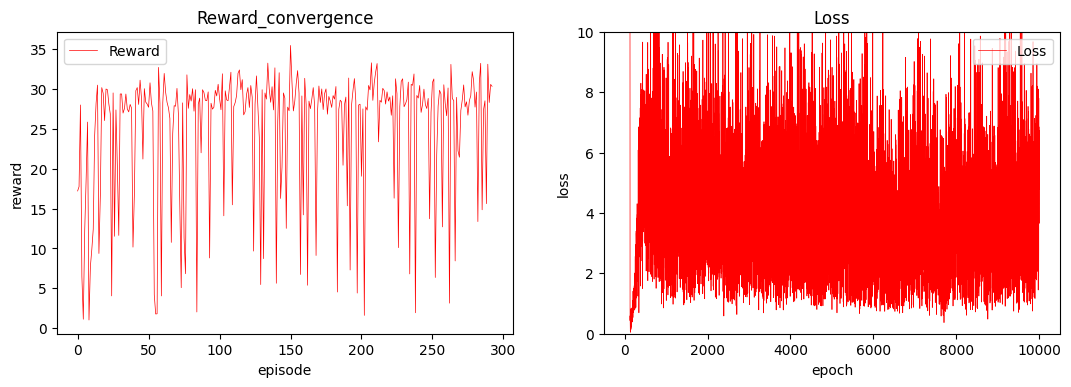

In [2]:
env = gym.make("highway-v0")
input_shape = env.observation_space.shape
num_actions = env.action_space.n

agent = Agent(
        input_shape, 
        num_actions,
        device,
        PATH,
        gamma = 0.95,
        learning_rate = 0.001,
        replay_size = 10000,
        batch_size = 128
        )

state_train  = Variable(torch.empty(1, 1, input_shape[0], input_shape[1])).to(device)
num_frames = 10000
losses = []
all_rewards = []
episode_reward = 0

state = env.reset().reshape(1,input_shape[0],input_shape[1])
for frame in range(num_frames):

    state_train[0] = Variable(torch.Tensor(np.array(state)))
    action = agent.get_action(state_train, frame)
    next_state, reward, done, info = env.step(action)
    next_state = next_state.reshape(1,input_shape[0],input_shape[1])

    agent.append_buffer(state, action, reward, next_state, done)

    episode_reward += reward
    state = next_state.copy()

    loss = agent.compute_loss()
    losses.append(loss)

    if frame % 10 == 0:
        agent.update_target_model()

        #print("epoch: %d/%d, loss: %1.8f" % (frame, num_frames, loss ))
    env.render()
     
    if done:
        all_rewards.append(episode_reward) 
        episode_reward = 0
        #env.reset()
        state = env.reset().reshape(1,input_shape[0],input_shape[1])
    
plt.figure(dpi=100, figsize=[20, 4])
plt.subplot(1, 3, 1)
plt.plot(all_rewards, c='r', linewidth=0.5, label = 'Reward')
plt.gca().set_title('Reward_convergence')
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(losses, c='r', linewidth=0.5, label = 'Loss')
plt.gca().set_title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.ylim(0, 10)
plt.show()
env.close()

## Double DQN 

In [3]:
import numpy as np
import gym
import highway_env
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable

from Utils.Double_DQN_Agent import Agent

PATH = "Trained_model/Double_DQN.pth"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

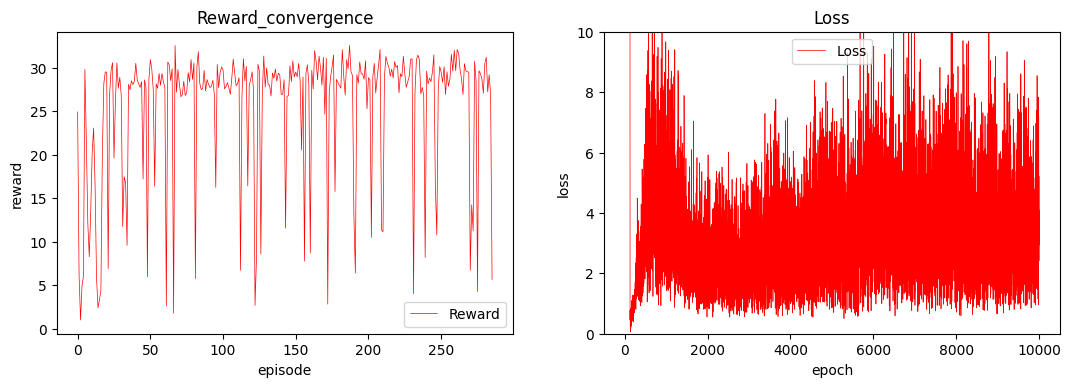

In [4]:
env = gym.make("highway-v0")
input_shape = env.observation_space.shape
num_actions = env.action_space.n

agent = Agent(
        input_shape, 
        num_actions,
        device,
        PATH,
        gamma = 0.95,
        learning_rate = 0.001,
        replay_size = 10000,
        batch_size = 128
        )

state_train  = Variable(torch.empty(1, 1, input_shape[0], input_shape[1])).to(device)
num_frames = 10000
losses = []
all_rewards = []
episode_reward = 0

state = env.reset().reshape(1,input_shape[0],input_shape[1])
for frame in range(num_frames):

    state_train[0] = Variable(torch.Tensor(np.array(state)))
    action = agent.get_action(state_train, frame)
    next_state, reward, done, info = env.step(action)
    next_state = next_state.reshape(1,input_shape[0],input_shape[1])

    agent.append_buffer(state, action, reward, next_state, done)

    episode_reward += reward
    state = next_state.copy()

    loss = agent.compute_loss()
    losses.append(loss)

    if frame % 10 == 0:
        agent.update_target_model()

        #print("epoch: %d/%d, loss: %1.8f" % (frame, num_frames, loss ))
    env.render()
     
    if done:
        all_rewards.append(episode_reward) 
        episode_reward = 0
        #env.reset()
        state = env.reset().reshape(1,input_shape[0],input_shape[1])
    
plt.figure(dpi=100, figsize=[20, 4])
plt.subplot(1, 3, 1)
plt.plot(all_rewards, c='r', linewidth=0.5, label = 'Reward')
plt.gca().set_title('Reward_convergence')
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(losses, c='r', linewidth=0.5, label = 'Loss')
plt.gca().set_title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.ylim(0, 10)
plt.show()
env.close()

## Dueling DQN 

In [5]:
import numpy as np
import gym
import highway_env
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable

from Utils.Dueling_DQN_Agent import Agent

PATH = "Trained_model/Dueling_DQN.pth"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

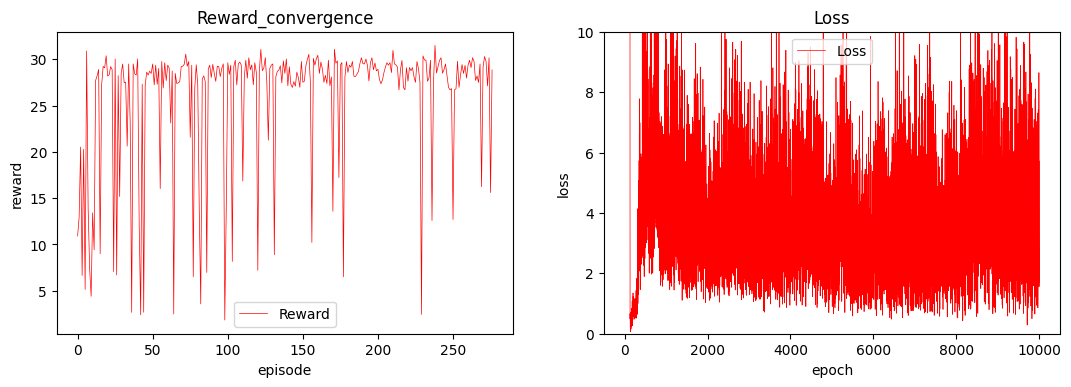

In [6]:
env = gym.make("highway-v0")
input_shape = env.observation_space.shape
num_actions = env.action_space.n

agent = Agent(
        input_shape, 
        num_actions,
        device,
        PATH,
        gamma = 0.95,
        learning_rate = 0.001,
        replay_size = 10000,
        batch_size = 128
        )

state_train  = Variable(torch.empty(1, 1, input_shape[0], input_shape[1])).to(device)
num_frames = 10000
losses = []
all_rewards = []
episode_reward = 0

state = env.reset().reshape(1,input_shape[0],input_shape[1])
for frame in range(num_frames):

    state_train[0] = Variable(torch.Tensor(np.array(state)))
    action = agent.get_action(state_train, frame)
    next_state, reward, done, info = env.step(action)
    next_state = next_state.reshape(1,input_shape[0],input_shape[1])

    agent.append_buffer(state, action, reward, next_state, done)

    episode_reward += reward
    state = next_state.copy()

    loss = agent.compute_loss()
    losses.append(loss)

    if frame % 10 == 0:
        agent.update_target_model()

        #print("epoch: %d/%d, loss: %1.8f" % (frame, num_frames, loss ))
    env.render()
     
    if done:
        all_rewards.append(episode_reward) 
        episode_reward = 0
        #env.reset()
        state = env.reset().reshape(1,input_shape[0],input_shape[1])
    
plt.figure(dpi=100, figsize=[20, 4])
plt.subplot(1, 3, 1)
plt.plot(all_rewards, c='r', linewidth=0.5, label = 'Reward')
plt.gca().set_title('Reward_convergence')
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(losses, c='r', linewidth=0.5, label = 'Loss')
plt.gca().set_title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.ylim(0, 10)
plt.show()
env.close()

## Prioritized DQN 

In [7]:
import numpy as np
import gym
import highway_env
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable

from Utils.Prioritized_DQN_Agent import Agent

PATH = "Trained_model/Prioritized_DQN.pth"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

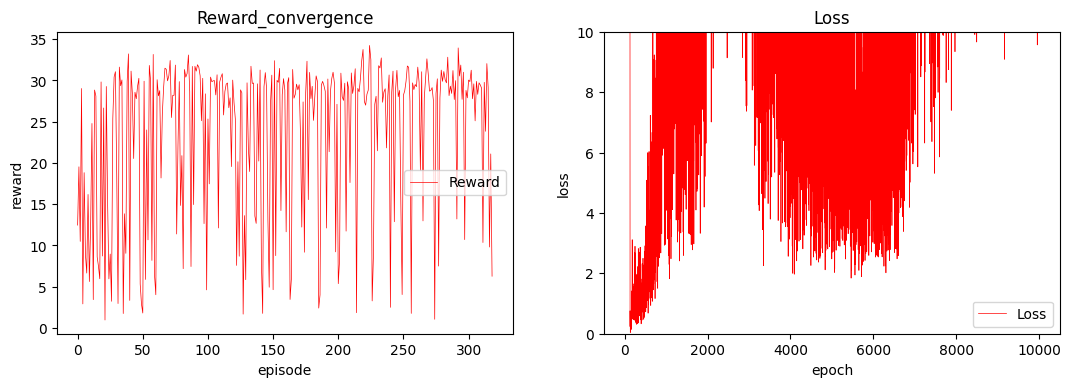

In [8]:
env = gym.make("highway-v0")
input_shape = env.observation_space.shape
num_actions = env.action_space.n

agent = Agent(
        input_shape, 
        num_actions,
        device,
        PATH,
        gamma = 0.95,
        learning_rate = 0.001,
        replay_size = 10000,
        batch_size = 128
        )

state_train  = Variable(torch.empty(1, 1, input_shape[0], input_shape[1])).to(device)
num_frames = 10000
losses = []
all_rewards = []
episode_reward = 0

state = env.reset().reshape(1,input_shape[0],input_shape[1])
for frame in range(num_frames):

    state_train[0] = Variable(torch.Tensor(np.array(state)))
    action = agent.get_action(state_train, frame)
    next_state, reward, done, info = env.step(action)
    next_state = next_state.reshape(1,input_shape[0],input_shape[1])

    agent.append_buffer(state, action, reward, next_state, done)

    episode_reward += reward
    state = next_state.copy()

    loss = agent.compute_loss()
    losses.append(loss)

    if frame % 10 == 0:
        agent.update_target_model()

        #print("epoch: %d/%d, loss: %1.8f" % (frame, num_frames, loss ))
    env.render()
     
    if done:
        all_rewards.append(episode_reward) 
        episode_reward = 0
        #env.reset()
        state = env.reset().reshape(1,input_shape[0],input_shape[1])
    
plt.figure(dpi=100, figsize=[20, 4])
plt.subplot(1, 3, 1)
plt.plot(all_rewards, c='r', linewidth=0.5, label = 'Reward')
plt.gca().set_title('Reward_convergence')
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(losses, c='r', linewidth=0.5, label = 'Loss')
plt.gca().set_title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.ylim(0, 10)
plt.show()
env.close()

## Rainbow DQN 

In [9]:
import numpy as np
import gym
import highway_env
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable

from Utils.Rainbow_DQN_Agent import Agent

PATH = "Trained_model/Rainbow_DQN.pth"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

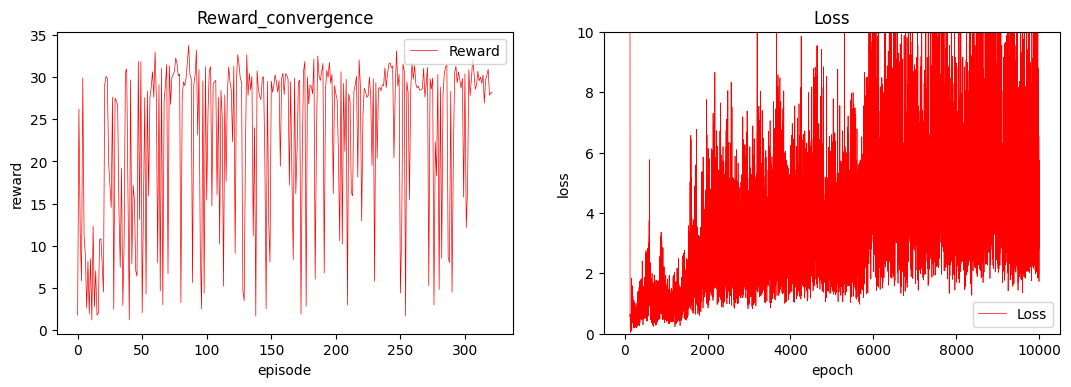

In [10]:
env = gym.make("highway-v0")
input_shape = env.observation_space.shape
num_actions = env.action_space.n

agent = Agent(
        input_shape, 
        num_actions,
        device,
        PATH,
        gamma = 0.95,
        learning_rate = 0.001,
        replay_size = 10000,
        batch_size = 128
        )

state_train  = Variable(torch.empty(1, 1, input_shape[0], input_shape[1])).to(device)
num_frames = 10000
losses = []
all_rewards = []
episode_reward = 0

state = env.reset().reshape(1,input_shape[0],input_shape[1])
for frame in range(num_frames):

    state_train[0] = Variable(torch.Tensor(np.array(state)))
    action = agent.get_action(state_train, frame)
    next_state, reward, done, info = env.step(action)
    next_state = next_state.reshape(1,input_shape[0],input_shape[1])

    agent.append_buffer(state, action, reward, next_state, done)

    episode_reward += reward
    state = next_state.copy()

    loss = agent.compute_loss()
    losses.append(loss)

    if frame % 10 == 0:
        agent.update_target_model()

        #print("epoch: %d/%d, loss: %1.8f" % (frame, num_frames, loss ))
    env.render()
     
    if done:
        all_rewards.append(episode_reward) 
        episode_reward = 0
        #env.reset()
        state = env.reset().reshape(1,input_shape[0],input_shape[1])
    
plt.figure(dpi=100, figsize=[20, 4])
plt.subplot(1, 3, 1)
plt.plot(all_rewards, c='r', linewidth=0.5, label = 'Reward')
plt.gca().set_title('Reward_convergence')
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(losses, c='r', linewidth=0.5, label = 'Loss')
plt.gca().set_title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.ylim(0, 10)
plt.show()
env.close()

episode: 1/1000, epoch: 1, loss: 9999.00000000
episode: 1/1000, epoch: 2, loss: 9999.00000000
episode: 1/1000, epoch: 3, loss: 9999.00000000
episode: 1/1000, epoch: 4, loss: 9999.00000000
episode: 1/1000, epoch: 5, loss: 9999.00000000
episode: 1/1000, epoch: 6, loss: 9999.00000000
episode: 1/1000, epoch: 7, loss: 9999.00000000
episode: 1/1000, epoch: 8, loss: 9999.00000000
episode: 1/1000, epoch: 9, loss: 9999.00000000
episode: 1/1000, epoch: 10, loss: 9999.00000000
episode: 1/1000, epoch: 11, loss: 9999.00000000
episode: 1/1000, epoch: 12, loss: 9999.00000000
episode: 1/1000, epoch: 13, loss: 9999.00000000
episode: 1/1000, epoch: 14, loss: 9999.00000000
episode: 1/1000, epoch: 15, loss: 9999.00000000


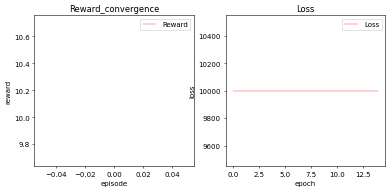

episode: 2/1000, epoch: 16, loss: 9999.00000000
episode: 2/1000, epoch: 17, loss: 9999.00000000
episode: 2/1000, epoch: 18, loss: 9999.00000000
episode: 2/1000, epoch: 19, loss: 9999.00000000
episode: 2/1000, epoch: 20, loss: 9999.00000000
episode: 2/1000, epoch: 21, loss: 9999.00000000
episode: 2/1000, epoch: 22, loss: 9999.00000000


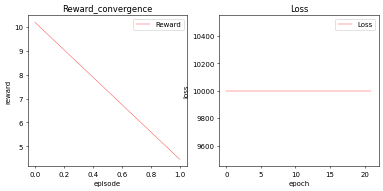

episode: 3/1000, epoch: 23, loss: 9999.00000000
episode: 3/1000, epoch: 24, loss: 9999.00000000
episode: 3/1000, epoch: 25, loss: 9999.00000000
episode: 3/1000, epoch: 26, loss: 9999.00000000
episode: 3/1000, epoch: 27, loss: 9999.00000000
episode: 3/1000, epoch: 28, loss: 9999.00000000
episode: 3/1000, epoch: 29, loss: 9999.00000000
episode: 3/1000, epoch: 30, loss: 9999.00000000
episode: 3/1000, epoch: 31, loss: 9999.00000000
episode: 3/1000, epoch: 32, loss: 9999.00000000
episode: 3/1000, epoch: 33, loss: 9999.00000000
episode: 3/1000, epoch: 34, loss: 9999.00000000
episode: 3/1000, epoch: 35, loss: 9999.00000000
episode: 3/1000, epoch: 36, loss: 9999.00000000
episode: 3/1000, epoch: 37, loss: 9999.00000000
episode: 3/1000, epoch: 38, loss: 9999.00000000
episode: 3/1000, epoch: 39, loss: 9999.00000000
episode: 3/1000, epoch: 40, loss: 9999.00000000
episode: 3/1000, epoch: 41, loss: 9999.00000000
episode: 3/1000, epoch: 42, loss: 9999.00000000
episode: 3/1000, epoch: 43, loss: 9999.0

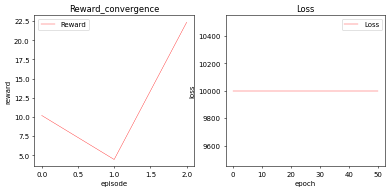

episode: 4/1000, epoch: 52, loss: 9999.00000000
episode: 4/1000, epoch: 53, loss: 9999.00000000
episode: 4/1000, epoch: 54, loss: 9999.00000000
episode: 4/1000, epoch: 55, loss: 9999.00000000
episode: 4/1000, epoch: 56, loss: 9999.00000000
episode: 4/1000, epoch: 57, loss: 9999.00000000
episode: 4/1000, epoch: 58, loss: 9999.00000000
episode: 4/1000, epoch: 59, loss: 9999.00000000
episode: 4/1000, epoch: 60, loss: 9999.00000000
episode: 4/1000, epoch: 61, loss: 9999.00000000
episode: 4/1000, epoch: 62, loss: 9999.00000000


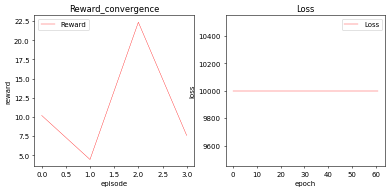

episode: 5/1000, epoch: 63, loss: 9999.00000000
episode: 5/1000, epoch: 64, loss: 9999.00000000
episode: 5/1000, epoch: 65, loss: 9999.00000000
episode: 5/1000, epoch: 66, loss: 9999.00000000
episode: 5/1000, epoch: 67, loss: 9999.00000000
episode: 5/1000, epoch: 68, loss: 9999.00000000
episode: 5/1000, epoch: 69, loss: 9999.00000000
episode: 5/1000, epoch: 70, loss: 9999.00000000
episode: 5/1000, epoch: 71, loss: 9999.00000000
episode: 5/1000, epoch: 72, loss: 9999.00000000
episode: 5/1000, epoch: 73, loss: 9999.00000000
episode: 5/1000, epoch: 74, loss: 9999.00000000
episode: 5/1000, epoch: 75, loss: 9999.00000000
episode: 5/1000, epoch: 76, loss: 9999.00000000
episode: 5/1000, epoch: 77, loss: 9999.00000000
episode: 5/1000, epoch: 78, loss: 9999.00000000
episode: 5/1000, epoch: 79, loss: 9999.00000000
episode: 5/1000, epoch: 80, loss: 9999.00000000
episode: 5/1000, epoch: 81, loss: 9999.00000000
episode: 5/1000, epoch: 82, loss: 9999.00000000
episode: 5/1000, epoch: 83, loss: 9999.0

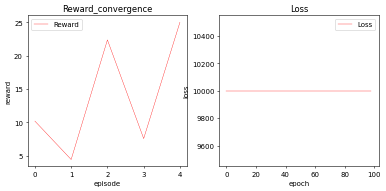

episode: 6/1000, epoch: 100, loss: 9999.00000000
episode: 6/1000, epoch: 101, loss: 9999.00000000
episode: 6/1000, epoch: 102, loss: 9999.00000000
episode: 6/1000, epoch: 103, loss: 9999.00000000
episode: 6/1000, epoch: 104, loss: 9999.00000000
episode: 6/1000, epoch: 105, loss: 9999.00000000
episode: 6/1000, epoch: 106, loss: 9999.00000000
episode: 6/1000, epoch: 107, loss: 9999.00000000
episode: 6/1000, epoch: 108, loss: 9999.00000000
episode: 6/1000, epoch: 109, loss: 9999.00000000
episode: 6/1000, epoch: 110, loss: 9999.00000000
episode: 6/1000, epoch: 111, loss: 9999.00000000
episode: 6/1000, epoch: 112, loss: 9999.00000000
episode: 6/1000, epoch: 113, loss: 9999.00000000
episode: 6/1000, epoch: 114, loss: 9999.00000000
episode: 6/1000, epoch: 115, loss: 9999.00000000
episode: 6/1000, epoch: 116, loss: 9999.00000000
episode: 6/1000, epoch: 117, loss: 9999.00000000
episode: 6/1000, epoch: 118, loss: 9999.00000000
episode: 6/1000, epoch: 119, loss: 9999.00000000
episode: 6/1000, epo

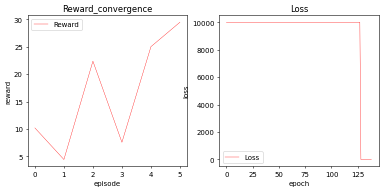

episode: 7/1000, epoch: 140, loss: 0.13935822
episode: 7/1000, epoch: 141, loss: 0.70750540
episode: 7/1000, epoch: 142, loss: 0.53594089
episode: 7/1000, epoch: 143, loss: 0.33762962
episode: 7/1000, epoch: 144, loss: 0.14571872
episode: 7/1000, epoch: 145, loss: 0.14361936
episode: 7/1000, epoch: 146, loss: 0.28014398
episode: 7/1000, epoch: 147, loss: 0.37249297
episode: 7/1000, epoch: 148, loss: 0.27208751
episode: 7/1000, epoch: 149, loss: 0.15409246
episode: 7/1000, epoch: 150, loss: 0.11725813
episode: 7/1000, epoch: 151, loss: 0.86801755
episode: 7/1000, epoch: 152, loss: 0.87431741
episode: 7/1000, epoch: 153, loss: 0.70942205
episode: 7/1000, epoch: 154, loss: 0.42122146
episode: 7/1000, epoch: 155, loss: 0.24138923
episode: 7/1000, epoch: 156, loss: 0.24855796
episode: 7/1000, epoch: 157, loss: 0.42543268
episode: 7/1000, epoch: 158, loss: 0.51159602
episode: 7/1000, epoch: 159, loss: 0.50860703
episode: 7/1000, epoch: 160, loss: 0.26715642
episode: 7/1000, epoch: 161, loss:

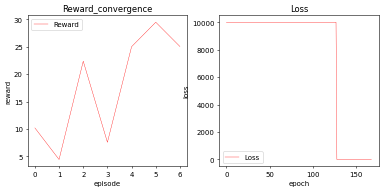

episode: 8/1000, epoch: 170, loss: 0.43917817
episode: 8/1000, epoch: 171, loss: 1.02294374
episode: 8/1000, epoch: 172, loss: 0.94537473
episode: 8/1000, epoch: 173, loss: 0.80621576
episode: 8/1000, epoch: 174, loss: 0.61549139
episode: 8/1000, epoch: 175, loss: 0.54104036
episode: 8/1000, epoch: 176, loss: 0.69358301
episode: 8/1000, epoch: 177, loss: 0.74298441
episode: 8/1000, epoch: 178, loss: 0.78574276
episode: 8/1000, epoch: 179, loss: 0.69894826
episode: 8/1000, epoch: 180, loss: 0.31505948
episode: 8/1000, epoch: 181, loss: 1.02553391
episode: 8/1000, epoch: 182, loss: 1.10183108
episode: 8/1000, epoch: 183, loss: 1.02944922


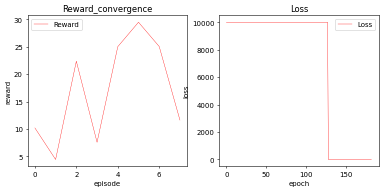

episode: 9/1000, epoch: 184, loss: 0.72651142
episode: 9/1000, epoch: 185, loss: 0.77222437
episode: 9/1000, epoch: 186, loss: 0.96359706
episode: 9/1000, epoch: 187, loss: 0.85839367
episode: 9/1000, epoch: 188, loss: 0.86135906
episode: 9/1000, epoch: 189, loss: 0.62863386
episode: 9/1000, epoch: 190, loss: 0.70843810
episode: 9/1000, epoch: 191, loss: 1.17372131
episode: 9/1000, epoch: 192, loss: 1.09302747
episode: 9/1000, epoch: 193, loss: 1.28625977


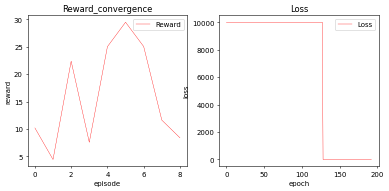

episode: 10/1000, epoch: 194, loss: 1.03651834
episode: 10/1000, epoch: 195, loss: 1.10161495
episode: 10/1000, epoch: 196, loss: 1.01984084
episode: 10/1000, epoch: 197, loss: 0.91186357
episode: 10/1000, epoch: 198, loss: 1.01839542


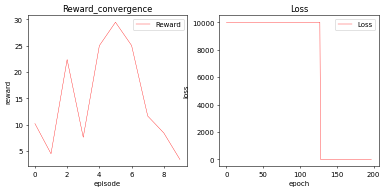

episode: 11/1000, epoch: 199, loss: 0.84008509
episode: 11/1000, epoch: 200, loss: 0.53173929
episode: 11/1000, epoch: 201, loss: 1.26392221
episode: 11/1000, epoch: 202, loss: 1.45503700


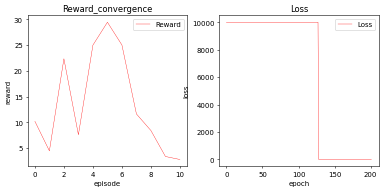

episode: 12/1000, epoch: 203, loss: 1.64685631
episode: 12/1000, epoch: 204, loss: 1.78262722
episode: 12/1000, epoch: 205, loss: 1.31968451
episode: 12/1000, epoch: 206, loss: 1.52820790
episode: 12/1000, epoch: 207, loss: 1.09413481
episode: 12/1000, epoch: 208, loss: 1.08709764


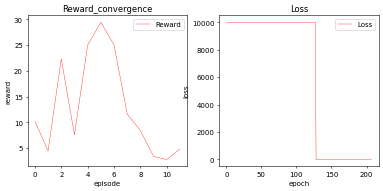

episode: 13/1000, epoch: 209, loss: 1.32028055
episode: 13/1000, epoch: 210, loss: 1.65438414
episode: 13/1000, epoch: 211, loss: 1.69967580
episode: 13/1000, epoch: 212, loss: 1.69125247
episode: 13/1000, epoch: 213, loss: 1.36757684
episode: 13/1000, epoch: 214, loss: 1.30286694
episode: 13/1000, epoch: 215, loss: 1.31789827
episode: 13/1000, epoch: 216, loss: 1.69180405
episode: 13/1000, epoch: 217, loss: 1.57784438
episode: 13/1000, epoch: 218, loss: 0.89009446
episode: 13/1000, epoch: 219, loss: 1.36422336
episode: 13/1000, epoch: 220, loss: 1.79584372
episode: 13/1000, epoch: 221, loss: 2.06225348
episode: 13/1000, epoch: 222, loss: 1.59797657
episode: 13/1000, epoch: 223, loss: 1.50540853
episode: 13/1000, epoch: 224, loss: 1.12457192
episode: 13/1000, epoch: 225, loss: 2.51942968
episode: 13/1000, epoch: 226, loss: 1.85080004
episode: 13/1000, epoch: 227, loss: 1.26918817
episode: 13/1000, epoch: 228, loss: 1.64302397
episode: 13/1000, epoch: 229, loss: 1.60083914
episode: 13/1

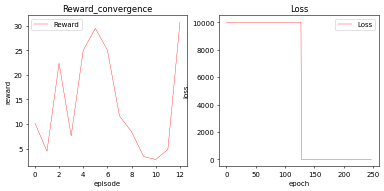

episode: 14/1000, epoch: 249, loss: 1.57364655
episode: 14/1000, epoch: 250, loss: 1.82832086
episode: 14/1000, epoch: 251, loss: 2.62303972
episode: 14/1000, epoch: 252, loss: 2.44441867
episode: 14/1000, epoch: 253, loss: 1.83933926
episode: 14/1000, epoch: 254, loss: 2.69574213
episode: 14/1000, epoch: 255, loss: 2.84547329
episode: 14/1000, epoch: 256, loss: 3.03719401
episode: 14/1000, epoch: 257, loss: 2.40633273
episode: 14/1000, epoch: 258, loss: 2.77722573
episode: 14/1000, epoch: 259, loss: 2.41700482
episode: 14/1000, epoch: 260, loss: 2.30354619
episode: 14/1000, epoch: 261, loss: 2.76546884
episode: 14/1000, epoch: 262, loss: 2.42776489
episode: 14/1000, epoch: 263, loss: 2.76072550
episode: 14/1000, epoch: 264, loss: 2.01928949
episode: 14/1000, epoch: 265, loss: 2.88626671
episode: 14/1000, epoch: 266, loss: 2.29897308
episode: 14/1000, epoch: 267, loss: 3.16973448


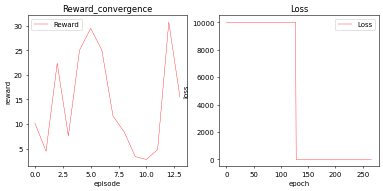

episode: 15/1000, epoch: 268, loss: 2.22971296
episode: 15/1000, epoch: 269, loss: 3.14634752
episode: 15/1000, epoch: 270, loss: 2.78139639


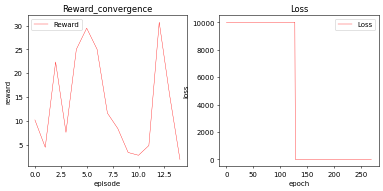

episode: 16/1000, epoch: 271, loss: 3.40863442
episode: 16/1000, epoch: 272, loss: 5.08448982
episode: 16/1000, epoch: 273, loss: 2.51971126
episode: 16/1000, epoch: 274, loss: 2.11645412
episode: 16/1000, epoch: 275, loss: 2.91765451
episode: 16/1000, epoch: 276, loss: 2.24184871
episode: 16/1000, epoch: 277, loss: 3.96343851
episode: 16/1000, epoch: 278, loss: 3.17332315
episode: 16/1000, epoch: 279, loss: 2.71305895
episode: 16/1000, epoch: 280, loss: 2.76960754
episode: 16/1000, epoch: 281, loss: 3.43159556
episode: 16/1000, epoch: 282, loss: 4.06469584
episode: 16/1000, epoch: 283, loss: 3.70333886
episode: 16/1000, epoch: 284, loss: 3.91038513
episode: 16/1000, epoch: 285, loss: 4.06657934
episode: 16/1000, epoch: 286, loss: 3.83650970
episode: 16/1000, epoch: 287, loss: 2.75893569
episode: 16/1000, epoch: 288, loss: 2.05241156
episode: 16/1000, epoch: 289, loss: 3.03627062
episode: 16/1000, epoch: 290, loss: 2.14866400
episode: 16/1000, epoch: 291, loss: 3.89829278
episode: 16/1

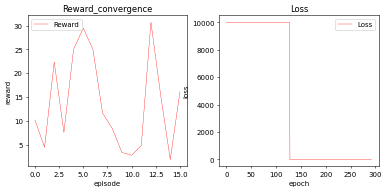

episode: 17/1000, epoch: 294, loss: 2.70881104
episode: 17/1000, epoch: 295, loss: 4.52029800
episode: 17/1000, epoch: 296, loss: 3.21492672
episode: 17/1000, epoch: 297, loss: 4.21431589
episode: 17/1000, epoch: 298, loss: 3.21146655
episode: 17/1000, epoch: 299, loss: 3.69138718
episode: 17/1000, epoch: 300, loss: 3.16809273
episode: 17/1000, epoch: 301, loss: 4.08976316
episode: 17/1000, epoch: 302, loss: 5.95983171
episode: 17/1000, epoch: 303, loss: 5.57111168
episode: 17/1000, epoch: 304, loss: 3.78784108
episode: 17/1000, epoch: 305, loss: 4.24825954
episode: 17/1000, epoch: 306, loss: 4.16987419
episode: 17/1000, epoch: 307, loss: 4.80825186
episode: 17/1000, epoch: 308, loss: 4.63923168
episode: 17/1000, epoch: 309, loss: 2.42637062
episode: 17/1000, epoch: 310, loss: 3.88590431
episode: 17/1000, epoch: 311, loss: 2.64508533
episode: 17/1000, epoch: 312, loss: 4.99871635
episode: 17/1000, epoch: 313, loss: 2.23157907
episode: 17/1000, epoch: 314, loss: 2.58165288
episode: 17/1

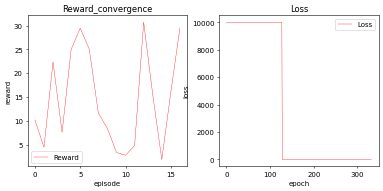

episode: 18/1000, epoch: 334, loss: 2.17125249
episode: 18/1000, epoch: 335, loss: 4.56399107
episode: 18/1000, epoch: 336, loss: 3.73853064
episode: 18/1000, epoch: 337, loss: 3.47924376
episode: 18/1000, epoch: 338, loss: 3.31943750
episode: 18/1000, epoch: 339, loss: 4.56492424
episode: 18/1000, epoch: 340, loss: 3.05732870
episode: 18/1000, epoch: 341, loss: 4.02944851
episode: 18/1000, epoch: 342, loss: 3.73021388
episode: 18/1000, epoch: 343, loss: 6.07346153
episode: 18/1000, epoch: 344, loss: 3.42516851
episode: 18/1000, epoch: 345, loss: 3.61813688
episode: 18/1000, epoch: 346, loss: 1.90989804


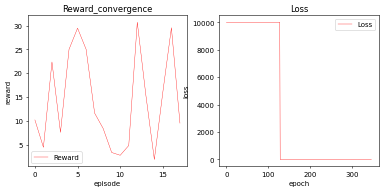

episode: 19/1000, epoch: 347, loss: 3.10434628
episode: 19/1000, epoch: 348, loss: 3.61818266
episode: 19/1000, epoch: 349, loss: 5.78128099
episode: 19/1000, epoch: 350, loss: 3.57634354
episode: 19/1000, epoch: 351, loss: 4.13226509
episode: 19/1000, epoch: 352, loss: 2.44895792
episode: 19/1000, epoch: 353, loss: 3.02480698
episode: 19/1000, epoch: 354, loss: 2.70815659
episode: 19/1000, epoch: 355, loss: 3.28676558
episode: 19/1000, epoch: 356, loss: 3.55090618
episode: 19/1000, epoch: 357, loss: 2.78109694
episode: 19/1000, epoch: 358, loss: 2.75817919
episode: 19/1000, epoch: 359, loss: 3.10619974
episode: 19/1000, epoch: 360, loss: 3.16264009
episode: 19/1000, epoch: 361, loss: 4.67079926
episode: 19/1000, epoch: 362, loss: 4.25072622
episode: 19/1000, epoch: 363, loss: 3.49314070
episode: 19/1000, epoch: 364, loss: 2.42516851
episode: 19/1000, epoch: 365, loss: 2.90372443
episode: 19/1000, epoch: 366, loss: 3.18433547
episode: 19/1000, epoch: 367, loss: 1.94996095
episode: 19/1

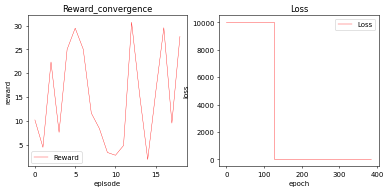

episode: 20/1000, epoch: 387, loss: 4.15277481
episode: 20/1000, epoch: 388, loss: 2.19845843
episode: 20/1000, epoch: 389, loss: 2.84981894
episode: 20/1000, epoch: 390, loss: 3.82136965
episode: 20/1000, epoch: 391, loss: 5.41963387
episode: 20/1000, epoch: 392, loss: 2.63053417
episode: 20/1000, epoch: 393, loss: 4.62538290
episode: 20/1000, epoch: 394, loss: 4.13510132
episode: 20/1000, epoch: 395, loss: 4.56488132
episode: 20/1000, epoch: 396, loss: 2.33834410
episode: 20/1000, epoch: 397, loss: 2.77880740
episode: 20/1000, epoch: 398, loss: 2.71943760
episode: 20/1000, epoch: 399, loss: 4.59930229
episode: 20/1000, epoch: 400, loss: 3.96988606
episode: 20/1000, epoch: 401, loss: 3.92581511
episode: 20/1000, epoch: 402, loss: 4.59447908
episode: 20/1000, epoch: 403, loss: 1.64807677
episode: 20/1000, epoch: 404, loss: 3.32431555
episode: 20/1000, epoch: 405, loss: 3.94622087
episode: 20/1000, epoch: 406, loss: 3.57944250
episode: 20/1000, epoch: 407, loss: 3.77552557
episode: 20/1

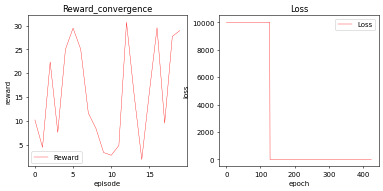

episode: 21/1000, epoch: 427, loss: 4.59328938
episode: 21/1000, epoch: 428, loss: 1.45834088
episode: 21/1000, epoch: 429, loss: 6.77665901
episode: 21/1000, epoch: 430, loss: 2.24929285
episode: 21/1000, epoch: 431, loss: 2.96496153
episode: 21/1000, epoch: 432, loss: 3.59299374
episode: 21/1000, epoch: 433, loss: 5.96268272
episode: 21/1000, epoch: 434, loss: 2.81258583
episode: 21/1000, epoch: 435, loss: 2.92529440
episode: 21/1000, epoch: 436, loss: 4.83506393
episode: 21/1000, epoch: 437, loss: 6.27296543
episode: 21/1000, epoch: 438, loss: 4.10171270
episode: 21/1000, epoch: 439, loss: 3.98712778
episode: 21/1000, epoch: 440, loss: 3.41915417
episode: 21/1000, epoch: 441, loss: 7.36387157
episode: 21/1000, epoch: 442, loss: 3.79515982
episode: 21/1000, epoch: 443, loss: 7.07797241
episode: 21/1000, epoch: 444, loss: 4.25272417
episode: 21/1000, epoch: 445, loss: 4.52192307
episode: 21/1000, epoch: 446, loss: 3.35704446
episode: 21/1000, epoch: 447, loss: 3.44137335
episode: 21/1

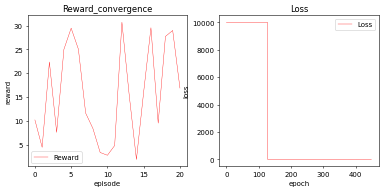

episode: 22/1000, epoch: 451, loss: 6.44602108
episode: 22/1000, epoch: 452, loss: 4.39076996
episode: 22/1000, epoch: 453, loss: 4.88172102
episode: 22/1000, epoch: 454, loss: 6.65057945
episode: 22/1000, epoch: 455, loss: 5.98724365
episode: 22/1000, epoch: 456, loss: 3.85949159
episode: 22/1000, epoch: 457, loss: 5.71952915


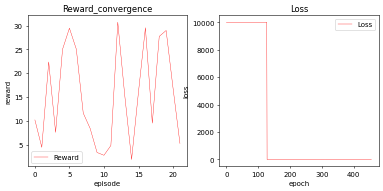

episode: 23/1000, epoch: 458, loss: 4.74604893
episode: 23/1000, epoch: 459, loss: 7.07664013


KeyboardInterrupt: 

In [8]:
num_episode = 1000
losses = []
all_rewards = []
epoch = 0
for episode in range(1, num_episode + 1):
    done = False

    state = env.reset().reshape(1,input_shape[0],input_shape[1])
    done = False
    episode_reward = 0
    while not done:

        state_train[0] = Variable(torch.Tensor(np.array(state)))
        action = agent.get_action(state_train, episode)
        next_state, reward, done, info = env.step(action)
        next_state = next_state.reshape(1,input_shape[0],input_shape[1])
        
        agent.append_buffer(state, action, reward, next_state, done)
        
        episode_reward += reward
        state = next_state.copy()
        
        loss = agent.compute_loss()
        losses.append(loss)
        epoch += 1
        
        if epoch % 10 == 0:
            agent.update_target_model()
        
        print("episode: %d/%d, epoch: %d, loss: %1.8f" % (episode, num_episode, epoch, loss ))
        env.render()
        
    all_rewards.append(episode_reward)
    
    plt.figure(dpi=50, figsize=[14, 4])
    plt.subplot(1, 3, 1)
    plt.plot(all_rewards, c='r', linewidth=0.5, label = 'Reward')
    plt.gca().set_title('Reward_convergence')
    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(losses, c='r', linewidth=0.5, label = 'Loss')
    plt.gca().set_title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
env.close()